In [1]:
# Imports
import sympy
import numpy
from sympy.sets.setexpr import SetExpr
from sympy.polys.orderings import monomial_key
from math import factorial, floor
from sympy.abc import t, x, y, s

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

from tm_integration import truncate_matrix, taylor_polynomials,\
                           picard_operator,\
                           refine_remainders, contractive_remainder,\
                           initial_set, create_box,\
                           tm_integration, tm_integration_iter

In [2]:
# Dynamics of Example 3.3.2 in Xin Chen's thesis
allvars = [x, y]
nxtstate = sympy.Matrix([1 + y, -(x ** 2)])

In [3]:
# Initial values
x0 = (0, 0.5)
y0 = (0, 0)
init = [x0, y0]
init_var = {x: sympy.Symbol("x_0"), y: sympy.Symbol("y_0")}

In [4]:
# Testing truncate_matrix
ORDER: int = 3
EXPR = 4 * x ** 3 + 2 * y ** 3 + 5 * x**2 * 2 * y ** 2 + x*y*y + x*y + 2*x*(y + 1) + 12 * x + y + 1
matrix = sympy.Matrix([EXPR])
print("degree = ", ORDER)
print("before; ", matrix)
print("after:  ", truncate_matrix(matrix, ORDER))

degree =  3
before;  Matrix([[4*x**3 + 10*x**2*y**2 + x*y**2 + x*y + 2*x*(y + 1) + 12*x + 2*y**3 + y + 1]])
after:   Matrix([[4*x**3 + x*y**2 + 3*x*y + 14*x + 2*y**3 + y + 1]])


In [5]:
# Compute Taylor polynomials of a chosen degree
deg = 3
TM0 = (sympy.Matrix([x, y]), init)

# We will be needing the Taylor expansion of the function defined by
# the dynamics
lieDers = [TM0[0]]  # the 0-th entry is the original TM
for i in reversed(range(deg)):
  J = lieDers[-1].jacobian(sympy.Matrix(allvars))  # FIXME: Trunc_{i} not done
  d = J * nxtstate  # FIXME: missing diff wrt time?
  lieDers.append(d)

# We are now ready to compute p1
tay = sum([d * (t ** i) / factorial(i) for i, d in enumerate(lieDers)],
          sympy.zeros(*lieDers[0].shape))
tay = tay.applyfunc(lambda e: sympy.expand(e, key=monomial_key('lex', allvars)))
tay
# FIXME: Yes, yes, I still have to truncate things, it seems hard in sympy!

Matrix([
[                              -t**3*x*y/3 - t**3*x/3 - t**2*x**2/2 + t*y + t + x],
[t**3*x**3/3 - t**3*y**2/3 - 2*t**3*y/3 - t**3/3 - t**2*x*y - t**2*x - t*x**2 + y]])

Beware of the code below! I am trying to do one Picard operation to get the interval missing for a full Taylor model (look up, we only have the polynomial so far).

In [6]:
# Substitute polynomial p(x, y, t) into vector field f(x, y)
toint = nxtstate.subs(zip(allvars, tay))
toint

Matrix([
[                                                                                                                                      t**3*x**3/3 - t**3*y**2/3 - 2*t**3*y/3 - t**3/3 - t**2*x*y - t**2*x - t*x**2 + y + 1],
[-(-t**3*x*(t**3*x**3/3 - t**3*y**2/3 - 2*t**3*y/3 - t**3/3 - t**2*x*y - t**2*x - t*x**2 + y)/3 - t**3*x/3 - t**2*x**2/2 + t*(t**3*x**3/3 - t**3*y**2/3 - 2*t**3*y/3 - t**3/3 - t**2*x*y - t**2*x - t*x**2 + y) + t + x)**2]])

In [7]:
# The '+ s' term before integration serves to add the initial remainder estimate
# J0 to the interval evaluation of the integral of e. See table 3.3. step 4. where
# something similar is done
pic = toint.applyfunc(lambda e: sympy.integrate(e + s, t))
pic

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       t**4*(x**3/12 - y**2/12 - y/6 - 1/12) + t**3*(-x*y/3 - x/3) - t**2*x**2/2 + t*(s + y + 1)],
[t**13*(-x**8/1053 + 2*x**5*y**2/1053 + 4*x**5*y/1053 + 2*x

In [8]:
pic = pic.applyfunc(lambda e: (sympy.expand(e) + sympy.O(t ** 5)).removeO())
pic

Matrix([
[                s*t + t**4*x**3/12 - t**4*y**2/12 - t**4*y/6 - t**4/12 - t**3*x*y/3 - t**3*x/3 - t**2*x**2/2 + t*y + t],
[s*t + 17*t**4*x**2*y/12 + 17*t**4*x**2/12 + t**3*x**3 - t**3*y**2/3 - 2*t**3*y/3 - t**3/3 - t**2*x*y - t**2*x - t*x**2]])

In [9]:
# allvars + pic = the full picard operator output expression.
# It is an over-approximation of the flow/true ODE solution?
# ==> Doing '- tay' essentially computes a remainder estimate?
onlys = sympy.Matrix(allvars) + pic - tay
onlys = onlys.applyfunc(lambda e: sympy.expand(e))
onlys

Matrix([
[   s*t + t**4*x**3/12 - t**4*y**2/12 - t**4*y/6 - t**4/12],
[s*t + 17*t**4*x**2*y/12 + 17*t**4*x**2/12 + 2*t**3*x**3/3]])

In [10]:
# We now evaluate the above on the intervals we have so far and a "guess"
# for the new intervals to see if we get something smaller than the guess
# This is based on https://stackoverflow.com/questions/59170963/sympy-interval-math
lerr = sympy.lambdify(tuple([x, y, t, s]), onlys)
xdom = sympy.plotting.intervalmath.interval(-0.002,0.002)
ydom = sympy.plotting.intervalmath.interval(-0.0021, 0.0021)
tdom = sympy.plotting.intervalmath.interval(0, 0.02)
I0 = sympy.plotting.intervalmath.interval(-0.1, 0.1)
Il = lerr(x=xdom, y=ydom, t=tdom, s=I0)
Il

array([[interval(-0.002000, 0.002000)],
       [interval(-0.002000, 0.002000)]], dtype=object)

## Test the building blocks for TM integration

Test the functions that operate as the building blocks of TM integration on the running example. This helps with intuition and trouble shooting.

In [11]:
# Manually check for the expected taylor polynomial
X0 = (sympy.Matrix([x, y]), init)
taylor_polynomials(X0[0], allvars, nxtstate, 3)

Matrix([
[                  t*y + t + x],
[-t**3/3 - t**2*x - t*x**2 + y]])

In [12]:
# Manually check for the exoected picard operator result.
order: int = 3
taylor_poly = taylor_polynomials(
    X0[0], allvars, order=order, ode=nxtstate)
picard_operator(taylor_poly, nxtstate, allvars, order)

Matrix([
[                 s*t + t*y + t + x],
[s*t - t**3/3 - t**2*x - t*x**2 + y]])

In [13]:
# Refine the given remainder intervals a single time.
refine_remainders(tay, nxtstate, allvars, ode_intervals=[
    sympy.plotting.intervalmath.interval(-0.002,0.002),    # x  w.r.t. ode_variables
    sympy.plotting.intervalmath.interval(-0.0021, 0.0021)  # y  w.r.t. ode_variables
], remainder_intervals=numpy.array([
    sympy.plotting.intervalmath.interval(-0.1, 0.1),  # x  w.r.t. ode_variables
    sympy.plotting.intervalmath.interval(-0.1, 0.1)   # y  w.r.t. ode_variables
]), time=sympy.plotting.intervalmath.interval(0, 0.02),
    order=3)

array([interval(-0.004042, 0.024042), interval(-0.004104, 0.004101)],
      dtype=object)

In [14]:
# Generate a contractive remainder Il that has ALSO been refined as
# many times as specified. So the output is not just an interval that
# has been verified to be contractive, but that is also refined.
contractive_remainder(tay, nxtstate, allvars, ode_intervals=numpy.array([
    sympy.plotting.intervalmath.interval(-0.002,0.002),    # x  w.r.t. ode_variables
    sympy.plotting.intervalmath.interval(-0.0021, 0.0021)  # y  w.r.t. ode_variables
]), initial_remainders=numpy.array([
    sympy.plotting.intervalmath.interval(-0.1, 0.1),  # x  w.r.t. ode_variables
    sympy.plotting.intervalmath.interval(-0.1, 0.1)   # y  w.r.t. ode_variables
]), time=sympy.plotting.intervalmath.interval(0, 0.02),
    order=3,
    nr_contractiveness_tries=10,
    contractiveness_scale=2.0,
    nr_refinements=1)


array([interval(-0.002123, 0.022523), interval(-0.002186, 0.002183)],
      dtype=object)

In [15]:
# Generate the initial set of the following tm integration iteration.
initial_set(picard_operator(tay, nxtstate, allvars, deg) - tay,
                 intervals=Il,
                 time_var=t,
                 time=tdom)

(Matrix([
 [                           0.02*s + 0.0002*x**2 + 2.66666666666667e-6*x*y + 2.66666666666667e-6*x],
 [0.02*s - 2.66666666666667e-6*x**3 + 0.0004*x*y + 2.66666666666667e-6*y**2 + 5.33333333333333e-6*y]]),
 array([[interval(-0.002000, 0.002000)],
        [interval(-0.002000, 0.002000)]], dtype=object))

## Manually work out a single TM integration step
Try to manually work out a single TM integration step. Start by manually choosing X0 and then generating X1 by piecing together functions.

In [16]:
#
# SETUP INPUTS
#

# Specify intervals for various variables.
ode_var_intervals = numpy.array([
    sympy.plotting.intervalmath.interval(-0.0020, 0.0020),  # x  w.r.t. ode_variables
    sympy.plotting.intervalmath.interval(-0.0021, 0.0021)   # y  w.r.t. ode_variables
])

initial_remainder_estimates = numpy.array([
    sympy.plotting.intervalmath.interval(-0.1, 0.1),  # s variable valuation w.r.t. x in the ode_variables
    sympy.plotting.intervalmath.interval(-0.1, 0.1)   # s variable valuation w.r.t. y in the ode_variables
])
time_interval = sympy.plotting.intervalmath.interval(0, 0.02)  # t variable valuation

# Specify the input ODE and related parameters
degree: int = 3     # Taylor polynomial pl degree
ode_vars = [x, y]   # Ordered list of all ODE variables
p0 = sympy.Matrix([x, y])   # The polynomial part of the very first initial set X0
X0 = (p0, [])   # The very first initial set X0
ode = sympy.Matrix([1 + y, -(x ** 2)])  # The ODEs to over-approximate




#
# STEP 1: Compute the Taylor approximation of the true flow
#

taylor_polys = taylor_polynomials(X0[0], ode_vars, ode, order=degree)



#
# STEP 2: Compute a safe remainder estimate.
#
Il = contractive_remainder(
    taylor_polys,
    ode,
    ode_vars,
    ode_intervals=ode_var_intervals,
    initial_remainders=initial_remainder_estimates,
    time=time_interval,
    order=degree,
    nr_contractiveness_tries=10,
    contractiveness_scale=2.0,
    nr_refinements=0)



#
# STEP 3: Compute next iteration's initial set
#
Xl = initial_set(taylor_polys, Il, t, time_interval)
Xl


(Matrix([
 [                              x + 0.02*y + 0.02],
 [-0.02*x**2 - 0.0004*x + y - 2.66666666666667e-6]]),
 array([interval(-0.004042, 0.024042), interval(-0.004104, 0.004101)],
       dtype=object))

## Figure out how to draw boxes to a plot
Plotting each TM flowpipe can be done using one interval enclosure per flowpipe. For a 2-dimensional ODE (i.e. x' = ..., y' = ... has exactly two vars: x and y) we can use 2D boxes to plot each flowpipe.

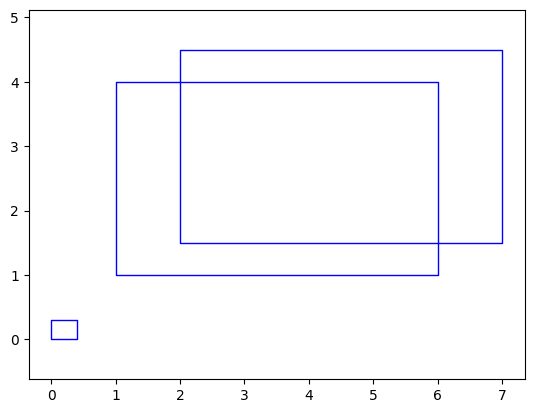

In [17]:
# Testing create_box
patches = []
patches.append(create_box(0, 0, 0.4, 0.3))
patches.append(create_box(1, 1, 6, 4))
patches.append(create_box(2, 1.5, 7, 4.5))
coll = PatchCollection(patches, match_original=True)
plt.gca().add_collection(coll)


plt.gca().axis('equal')
plt.show()

## Manually string together TM integration calls

First string together a few tm integration calls manually to figure out how the actual integration loop fits together.

In [18]:
# Specify intervals for various variables.
ode_var_intervals = numpy.array([
    sympy.plotting.intervalmath.interval(-0.0020, 0.0020),  # x  w.r.t. ode_variables
    sympy.plotting.intervalmath.interval(-0.0021, 0.0021)   # y  w.r.t. ode_variables
])

initial_remainder_estimates = numpy.array([
    sympy.plotting.intervalmath.interval(-0.1, 0.1),  # s variable valuation w.r.t. x in the ode_variables
    sympy.plotting.intervalmath.interval(-0.1, 0.1)   # s variable valuation w.r.t. y in the ode_variables
])
time_interval = sympy.plotting.intervalmath.interval(0, 0.02)  # t variable valuation

# Specify the input ODE and related parameters
degree: int = 3     # Taylor polynomial pl degree
ode_vars = [x, y]   # Ordered list of all ODE variables
p0 = sympy.Matrix([x, y])   # The polynomial part of the very first initial set X0
X0 = (p0, initial_remainder_estimates)  # The very first initial set X0
ode = sympy.Matrix([1 + y, -(x ** 2)])  # The ODEs to over-approximate

X1 = tm_integration_iter(
    X0, ode, ode_vars, ode_var_intervals, initial_remainder_estimates,
    degree, 10, 2.0, 0, time_interval.end
)
X1

(Matrix([
 [                              x + 0.02*y + 0.02],
 [-0.02*x**2 - 0.0004*x + y - 2.66666666666667e-6]]),
 array([interval(-0.004042, 0.024042), interval(-0.004104, 0.004101)],
       dtype=object))

In [19]:
X2 = tm_integration_iter(
    X1, ode, ode_vars, ode_var_intervals, initial_remainder_estimates,
    degree, 10, 2.0, 0, time_interval.end
)
X2

(Matrix([
 [              -0.0004*x**2 + 0.999992*x + 0.04*y + 0.0399999466666667],
 [-0.04*x**2 - 0.0008*x*y - 0.0016*x + 0.999976*y - 2.13333333333333e-5]]),
 array([interval(-0.004042, 0.024042), interval(-0.004121, 0.004102)],
       dtype=object))

In [20]:
X3 = tm_integration_iter(
    X2, ode, ode_vars, ode_var_intervals, initial_remainder_estimates,
    degree, 10, 2.0, 0, time_interval.end
)
X3

(Matrix([
 [                       -0.0012*x**2 - 1.6e-5*x*y + 0.99996*x + 0.05999952*y + 0.05999952],
 [-0.05999952*x**2 - 0.0024*x*y - 0.0035999904*x - 1.6e-5*y**2 + 0.999896*y - 7.1999936e-5]]),
 array([interval(-0.004043, 0.024042), interval(-0.004155, 0.004104)],
       dtype=object))

## Automatic TM integration V1

Now try to come manually up with the tm integration loop, which should produce a list of tm flowpipe over-approximations.

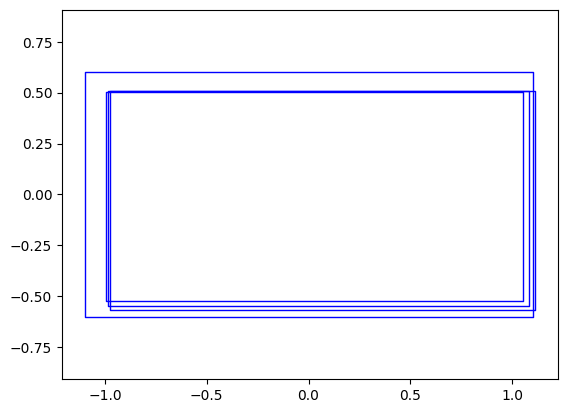

In [21]:
initial_box = numpy.array([
    sympy.plotting.intervalmath.interval(-1.0, 1.0),  # x  w.r.t. ode_variables
    sympy.plotting.intervalmath.interval(-0.5, 0.5)   # y  w.r.t. ode_variables
])



# The ode variables take on the same interval value regardless of which component
# in the taylor polynomial vector.
interval_values = {
    var: interval
    for var, interval in zip(ode_vars, initial_box)
}

# Xl is fixed at t = δi???? So pl does not 
tm_flowpipes = [X0, X1, X2, X3]
patches = []
for i, fp in enumerate(tm_flowpipes):
    # Unpack flowpipe into polynomial pl(Xl, δi) and remainder Il
    pl, Il = fp

    # Compute interval enclosure of the flowpipe
    enclosure = sympy.lambdify(ode_vars, pl)(
        **{ var.name: interval for var, interval in interval_values.items() }
    )
    # Peel away redundant layer of nesting: [[ix], [iy], ...] => [ix, iy]
    # Turn a list of one-element lists into just a list of elements.
    if len(enclosure.shape) > 1:
        enclosure = numpy.concatenate(enclosure).ravel()
    
    # The remainder represents the uncertainty/error on the polynomial's enclosure.
    enclosure = enclosure + Il

    # Generate 2D box for visualization
    assert enclosure.shape == (2,), "Cannot visualize, expected one 2-dimensional box."
    boxx, boxy = enclosure
    patches.append(create_box(boxx.start, boxy.start, boxx.end, boxy.end))


coll = PatchCollection(patches, match_original=True)
plt.gca().add_collection(coll)
plt.gca().axis('equal')
plt.show()

## Automatic TM integration V2

Call the complete TM integration function and plot the resulting boxes.

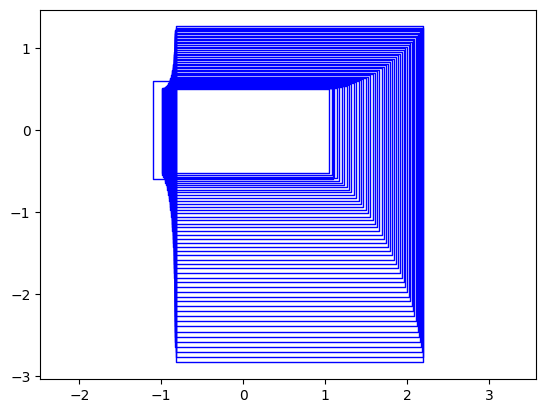

In [22]:
initial_box = numpy.array([
    sympy.plotting.intervalmath.interval(-1.0, 1.0),  # x  w.r.t. ode_variables
    sympy.plotting.intervalmath.interval(-0.5, 0.5)   # y  w.r.t. ode_variables
])


time_horizon = sympy.plotting.intervalmath.interval(0, 1.0)
nr_contractiveness_tries = 10
contractiveness_scale = 2.0
nr_refinements = 0
time_step_size = 0.02
time_step_epsilon = 0.0001

tm_flowpipes, boxes = tm_integration(
               ode_vars,
               ode,
               ode_var_intervals,

               initial_box,
               initial_remainder_estimates,

               time_horizon,
               time_step_size,
               time_step_epsilon,

               degree,
               nr_contractiveness_tries,
               contractiveness_scale,
               nr_refinements)

coll = PatchCollection(boxes, match_original=True)
plt.gca().add_collection(coll)
plt.gca().axis('equal')
plt.show()